In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import numpy as np
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

In [2]:
import Functions

In [3]:
test = Functions.getTimeSeries("Twisted bow", "6h")
test

timestamp
2023-01-02 12:00:00    1.293211e+09
2023-01-02 18:00:00    1.291199e+09
2023-01-03 00:00:00    1.290332e+09
2023-01-03 06:00:00    1.289213e+09
2023-01-03 12:00:00    1.288074e+09
                           ...     
2023-04-02 12:00:00    1.373733e+09
2023-04-02 18:00:00    1.375792e+09
2023-04-03 00:00:00    1.374825e+09
2023-04-03 06:00:00    1.376676e+09
2023-04-03 12:00:00    1.377667e+09
Length: 365, dtype: float64

In [4]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123), lags= 165
             )

data = Functions.getDT("Twisted bow", "6h")
data = data.drop(columns=['avgLowPrice', 'avgHighPrice'])
data = data.reset_index()
data['date'] = pd.to_datetime(data['timestamp'])
data= data.drop(columns=['timestamp'])
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data['average']
data = data.asfreq("6h")
data = data.sort_index()

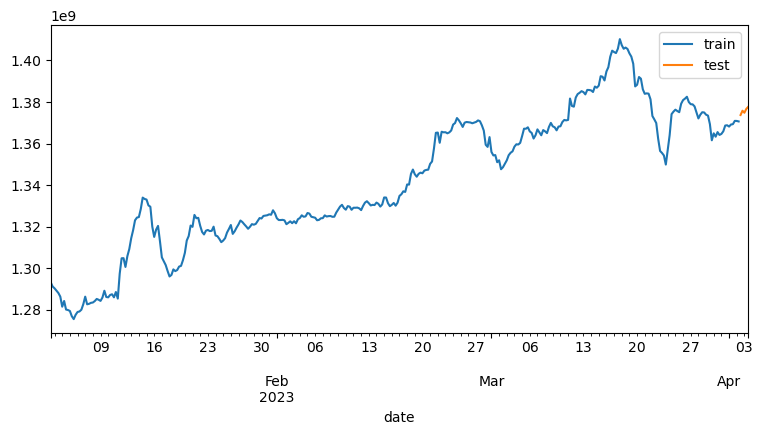

In [5]:
steps = 5
data_train = data[:-steps]
data_test  = data[-steps:]

fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

In [6]:
forecaster_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=123),
                    lags=(steps)
                )

forecaster_rf.fit(y = data_train)

predictions = forecaster_rf.predict(steps=steps)
predictions = pd.Series(data=predictions.tolist(), index=data_test.index)

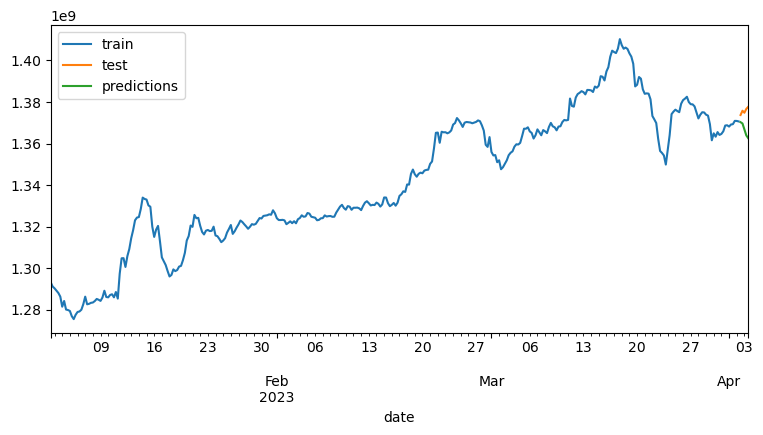

In [7]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [8]:
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 12 # This value will be replaced in the grid search
                 )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 300],
              'max_depth': range(10,15)}

# Lags used as predictors
lags_grid = range(10,20)

results_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = data_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                   )

Number of models compared: 100.


loop lags_grid: 100%|█████████████████████████████████████| 10/10 [01:25<00:00,  8.51s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'max_depth': 12, 'n_estimators': 300}
  Backtesting metric: 1763180622983815.0



In [9]:
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)

forecaster_rf = ForecasterAutoreg(
                    regressor = regressor,
                    lags      = 20
                )

forecaster_rf.fit(y=data_train)

In [10]:
# Predictions
# ==============================================================================
predictions = forecaster_rf.predict(steps=steps)
# Temporal index is added to predictions
predictions = pd.Series(data=predictions.tolist(), index=data_test.index)

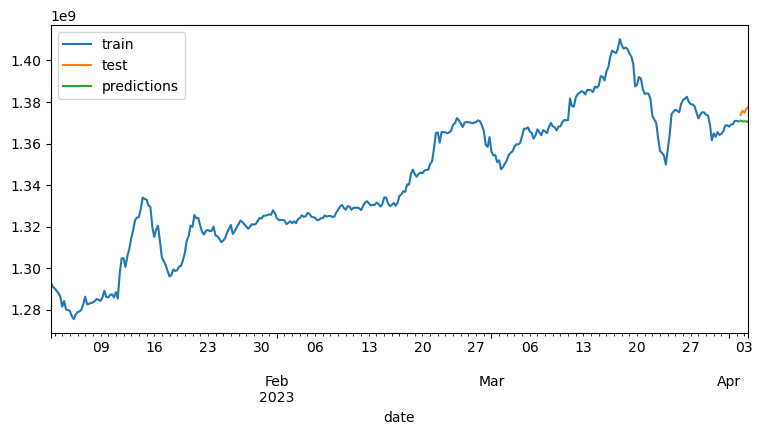

In [11]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [12]:
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}") # yikes

Test error (mse): 28251207952496.7
